In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
from keras.callbacks import TensorBoard
from keras import backend as K


import tensorflow as tf
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot

import numpy as np
import scipy.io
from PIL import Image
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing
from IPython import display
import time

img_rows, img_cols, img_depth = 64, 64, 64

/home/xd/ws/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/xd/ws/tf/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
root_dir = 'dataset/'
listing = os.listdir(root_dir)
maxval = 0.46
classes = {'none':0, 'left':1, 'right':2, 'click':3, 'wrist':4}
gs_class = {'left', 'right', 'click', 'wrist'}

In [3]:
X = []
y = []

for file in listing:
    file = root_dir + file
    data = scipy.io.loadmat(file)
    
    gt = 'none'
    for i in gs_class:
        idx = file.find(i)
        if idx != -1:
            gt = i
            break;
        
        
    raw = data['raw']
    label = data['label']
    speed = data['speed']
    phase = data['phase']
    mask = data['mask']
    
    if np.sum(label) > 30:
        label_binary = (label != 0)
        mask_sub = mask[label_binary[:,0], :]
        
        mask_sum = np.sum(mask_sub, 0)
        max_idx = np.argmax(mask_sum) # position of body
        
        gesture_index, b = np.nonzero(label)
        gesture_beg = gesture_index[0]
        gesture_end = gesture_index[-1]
        
        if max_idx < 100 or  max_idx > 200:
            continue
        
        for r in range(max(gesture_beg - 10,0), gesture_beg + 10):
            for c in range(max_idx - 5, max_idx + 5):
                r_min = r
                r_max = r + 64
                
                c_min = c - 64
                c_max = c
                
                raw_sub = raw[r_min:r_max, c_min:c_max]
                phase_sub = phase[r_min:r_max, c_min:c_max]
                speed_sub = speed[r_min:r_max, c_min:c_max]
                
                maxval = np.max(np.abs(raw_sub))
                if maxval == 0:
                    continue
                raw_sub = raw_sub / maxval
                maxval = np.max(np.abs(phase_sub))
                if maxval == 0:
                    continue
                phase_sub = phase_sub / maxval
                maxval = np.max(np.abs(speed_sub))
                if maxval == 0:
                    continue
                speed_sub = speed_sub / maxval
                
                X_i = np.zeros((64,64,3))
                X_i[:,:,0] = raw_sub
                X_i[:,:,1] = phase_sub
                X_i[:,:,2] = speed_sub
                X.append(X_i)
                
                y.append(classes[gt])
                

                if gt == 'wrist' or gt == 'click':
                    for itr in range(3):
                        X.append(X_i)
                        y.append(classes[gt])
                
        for r in range(gesture_end, min(gesture_end+10, len(label)-64)):
            for c in range(max_idx - 5, max_idx + 5):
                r_min = r
                r_max = r + 64
                
                c_min = c - 64
                c_max = c
                
                raw_sub = raw[r_min:r_max, c_min:c_max]
                phase_sub = phase[r_min:r_max, c_min:c_max]
                speed_sub = speed[r_min:r_max, c_min:c_max]
                
                maxval = np.max(np.abs(raw_sub))
                if maxval == 0:
                    continue
                raw_sub = raw_sub / maxval
                maxval = np.max(np.abs(phase_sub))
                if maxval == 0:
                    continue
                phase_sub = phase_sub / maxval
                maxval = np.max(np.abs(speed_sub))
                if maxval == 0:
                    continue
                speed_sub = speed_sub / maxval
                
                X_i = np.zeros((64,64,3))
                X_i[:,:,0] = raw_sub
                X_i[:,:,1] = phase_sub
                X_i[:,:,2] = speed_sub
                X.append(X_i)
                
                y.append(classes['none'])

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
labels = np.zeros((5))
for i in range(0, 5):
    labels[i] = np.sum(y == i)
    
# plt.hist(np.transpose(labels))
for i in range(5):
    print(labels[i])
    

36557.0
39900.0
23790.0
31656.0
35324.0


In [7]:
batch_size = 32
num_classes = 5
num_epoch = 20

In [8]:
y = np_utils.to_categorical(y, num_classes)

num_filters = [32, 32]
num_pool = [2, 2]
num_conv = [5, 3]

X = X.astype('float32')

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
K.clear_session()
model = Sequential()
print(num_filters[0], 'filters')
print('input shape', img_rows, 'rows', img_cols, 'cols')

model.add(Conv2D(16,
                 (5, 5),
                 input_shape=(64, 64, 3),
                 activation='relu',
                 padding='SAME'))

model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.5))

model.add(Conv2D(32,
                 (5, 5),
                 input_shape=(img_rows, img_cols, 1),
                 activation='relu',
                 padding='SAME'))

model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.5))

# model.add(Conv2D(64,
#                  (3, 3),
#                  input_shape=(img_rows, img_cols, 1),
#                  activation='relu',
#                  padding='valid'))

# model.add(MaxPooling2D(pool_size=2, strides=2))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_initializer='normal'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])

model.summary()

32 filters
input shape 64 rows 64 cols
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5

In [11]:
hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_val, y_val),
                 batch_size=batch_size,
                 epochs=num_epoch,
                 shuffle=True,
                 callbacks=[TensorBoard(log_dir='./tmp/log')]
)

Train on 133781 samples, validate on 33446 samples
Epoch 1/20
133781/133781 [==============================] - 27s 201us/step - loss: 0.5147 - mean_squared_error: 0.0531 - acc: 0.8129 - val_loss: 0.2191 - val_mean_squared_error: 0.0212 - val_acc: 0.9411
Epoch 2/20
133781/133781 [==============================] - 25s 190us/step - loss: 0.3259 - mean_squared_error: 0.0332 - acc: 0.8883 - val_loss: 0.2076 - val_mean_squared_error: 0.0192 - val_acc: 0.9590
Epoch 3/20
133781/133781 [==============================] - 26s 191us/step - loss: 0.2958 - mean_squared_error: 0.0295 - acc: 0.9021 - val_loss: 0.2342 - val_mean_squared_error: 0.0223 - val_acc: 0.9386
Epoch 4/20
133781/133781 [==============================] - 26s 193us/step - loss: 0.2854 - mean_squared_error: 0.0278 - acc: 0.9075 - val_loss: 0.2759 - val_mean_squared_error: 0.0272 - val_acc: 0.9241
Epoch 5/20
133781/133781 [==============================] - 26s 197us/step - loss: 0.2841 - mean_squared_error: 0.0274 - acc: 0.9096 - va

In [12]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

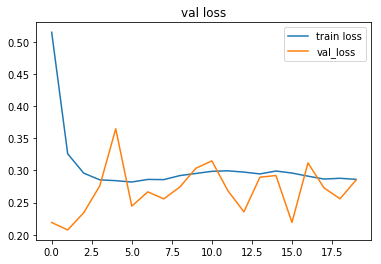

In [13]:
plt.plot(train_loss); plt.title('train loss')
plt.plot(val_loss); plt.title('val loss')
plt.legend(['train loss', 'val_loss'])

(0, 1)

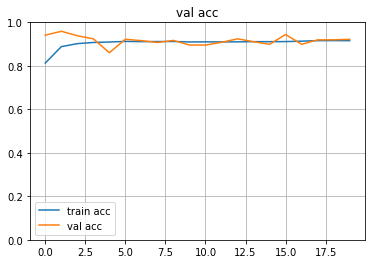

In [14]:
plt.plot(train_acc); plt.title('train acc')
plt.plot(val_acc); plt.title('val acc')
plt.legend(['train acc', 'val acc'])
plt.grid(True)
plt.ylim(0,1)

In [149]:
gestures = ['none', 'left', 'right', 'click', 'wrist']

In [15]:
np.save('X.npy', X)
np.save('y.npy', y)